### Problem 3: Object Detection

a)Understand the definition of object detection: (url)

b)Describe the difference between Object Localization & Object Detection?

c)Explore the ILSVRC2014 dataset (url). Understand the format of the annotations.

d)Randomly select 100 images and draw the ground truth bounding boxes along with the corresponding class label.

e)What can be the metric to validate the model predictions? You have done this before.

f)Oftentimes, the model will produce multiple detections for the same object. As a post-processing step, a non-maxima suppression algorithm selects the best box, filtering the rest. Read about non-maxima suppression here - (url). Implement the non-maxima suppression algorithm by creating random boxes by distorting a ground truth box. Visualize the best box that the non-maxima suppression algo produces

### Object detection
 Object detection encompasses the simultaneous localization and classification of objects within images. 

 **Localization:**
   - Determining the bounding box position and size

 **Classification:**
   - Assigning a label indicating the object category

## Difference between object localization and Detection
### Object Localization
- Object localization refers to the process of determining the precise location and size of an object within an image.
- It involves identifying the spatial extent of the object by defining a bounding box around it.
- The bounding box typically consists of coordinates that specify the object's position, such as its top-left corner (xmin, ymin) and bottom-right corner (xmax, ymax), as well as its dimensions (width and height).
- Object localization is crucial for tasks like object tracking, where the goal is to follow the movement of objects across frames in a video.

### Object Detection
- Object detection extends beyond localization by not only identifying the objects' locations but also classifying them into predefined categories.
- In addition to determining the bounding box coordinates, object detection algorithms assign a label or category to each detected object, indicating what type of object it is (e.g., person, car, dog).
- This classification step enables the system to provide richer information about the objects present in the image, facilitating tasks such as content-based image retrieval, scene understanding, and autonomous driving.


### Approach:

**Data Preparation:**
1. **Load XML annotation files:** Extract class labels and bounding box coordinates from XML annotation files.
2. **Prepare selected images:** Create a list of selected images for each category, ensuring a minimum of 5 images per category.

**Bounding Box Generation:**
1. **For each selected image:**
   - Generate three bounding boxes around the ground truth object, with variations in size.
   - Calculate the probability score for each bounding box based on Intersection over Union (IoU) with the ground truth.

**Visualization:**
1. **Plot images:**
   - Display each image with two subplots:
     - The original image showing the ground truth bounding box in red.
     - The modified image showing additional bounding boxes with probabilities and the original bounding box in green.

**Non-Maximum Suppression (NMS):**
1. **Apply NMS algorithm:**
   - Use the NMS algorithm to filter redundant bounding boxes based on their confidence scores and an IoU threshold.

**Display Results:**
1. **Display images with filtered bounding boxes:** Show the images with filtered bounding boxes after applying NMS.

### Non-Maximum Suppression (NMS) in Detail:

**Algorithm:**
1. **Sort bounding boxes by confidence scores:** Sort the bounding boxes in descending order based on their confidence scores.
2. **Initialize an empty list to store selected boxes' indices.**
3. **Iterate through the sorted bounding boxes:**
   - For each bounding box:
     - If it hasn't been suppressed:
       - Add its index to the list of selected boxes' indices.
       - Calculate IoU scores between the current box and all other selected boxes.
       - Filter out indices of boxes with IoU scores below the threshold.
       - Update the list of selected boxes' indices with non-maximum scoring boxes.
4. **Return the list of selected boxes' indices.**




In [66]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Function to parse XML annotation files
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Extract class label
    obj = root.find('object')
    class_label = obj.find('name').text
    
    # Extract bounding box coordinates
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    
    return class_label, (xmin, ymin, xmax, ymax)

def plot_image_with_bboxes_and_probabilities(image_path, class_label, original_bbox, all_bboxes, original_prob, all_probs, image_name):
    # Load images
    original_image = plt.imread(image_path)
    modified_image = original_image.copy()
    
    # Create figure and axes for subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the original image with ground truth bounding box
    axes[0].imshow(original_image)
    
    # Draw original bounding box in red
    original_rect = patches.Rectangle((original_bbox[0], original_bbox[1]), original_bbox[2]-original_bbox[0], original_bbox[3]-original_bbox[1], linewidth=1, edgecolor='red', facecolor='none')
    axes[0].add_patch(original_rect)
    
    axes[0].set_title(f"Ground truth - {class_label} - ({image_name})")
    axes[0].axis('off')
    
    # Display the modified image with additional bounding boxes and probabilities
    for bbox, prob in zip(all_bboxes, all_probs):
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='black', facecolor='none')
        modified_image = cv2.rectangle(modified_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2)
        axes[1].text(bbox[0], bbox[1], f'{prob:.2f}', color='black', fontsize=8, verticalalignment='top')
    
    # Draw original bounding box on modified image in green
    modified_image = cv2.rectangle(modified_image, (original_bbox[0], original_bbox[1]), (original_bbox[2], original_bbox[3]), (0, 255, 0), 2)
    
    axes[1].imshow(modified_image)
    axes[1].set_title(f"Multiple detections - {class_label} - ({image_name})")
    axes[1].axis('off')
    
    plt.show()

In [81]:
def calculate_iou(box1, box2):
    # Calculate Intersection over Union (IoU) between two bounding boxes
    x1, y1, w1, h1 = box1 
    x2, y2, w2, h2 = box2  

    # Calculate coordinates of the intersection rectangle
    intersectionx1 = max(x1, x2)
    intersectiony1 = max(y1, y2)
    intersectionx2 = min(x1 + w1, x2 + w2)
    intersectiony2 = min(y1 + h1, y2 + h2)
    intersect_area = max(0, intersectionx2 - intersectionx1 + 1) * max(0, intersectiony2 - intersectiony1 + 1)

    box1_area = (w1 + 1) * (h1 + 1)
    box2_area = (w2 + 1) * (h2 + 1)
    iou = intersect_area / float(box1_area + box2_area - intersect_area)
    return iou

In [82]:
# Apply Non-Maxima Suppression (NMS) to filter redundant boxes
def nms_algorithm(boxes, scores, iou_threshold):
    # Create a dictionary to store bounding box indices based on scores
    box_dict = {score: i for i, score in enumerate(scores)}

    # Sort the scores in descending order
    sorted_scores = sorted(scores, reverse=True)

    # Initialize a list to store indices of selected boxes
    selected_indices = []

    # Iterate through sorted scores
    for score in sorted_scores:
        current_index = box_dict[score]
        
        # If the current box has been suppressed, skip it
        if current_index in selected_indices:
            continue

        selected_indices.append(current_index)
        current_box = boxes[current_index]

        # Calculate IoU scores between the current box and all other selected boxes
        iou_scores = [calculate_iou(current_box, boxes[idx]) for idx in selected_indices[:-1]]

        # Filter indices of boxes with IoU scores below the threshold
        below_threshold_indices = [idx for idx, iou_score in zip(selected_indices[:-1], iou_scores) if iou_score <= iou_threshold]

        # Remove suppressed boxes from selected indices
        selected_indices = [idx for idx in selected_indices if idx not in below_threshold_indices]

    return selected_indices


In [83]:
# Path to dataset and annotation folders
dataset_folder = "dataset"
annotation_folder = "Annotation"

# List of categories
categories = ["n02099601", "n02326432", "n02397096"]

# Mapping of class IDs to labels
class_labels = {
    "n02099601": "golden retriever",
    "n02326432": "hare",
    "n02397096": "warthog"
}


Category: n02099601


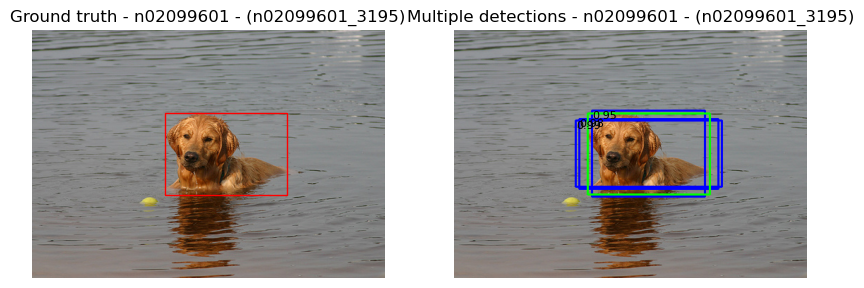

Category: n02326432


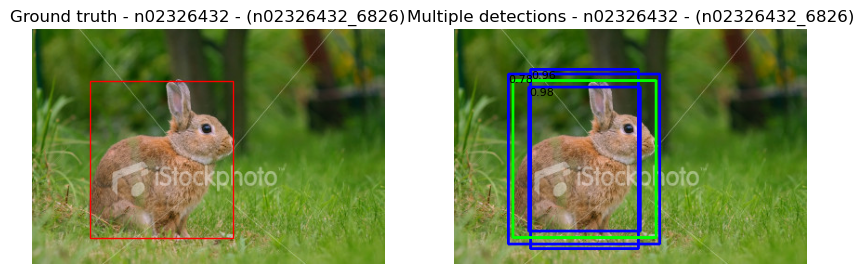

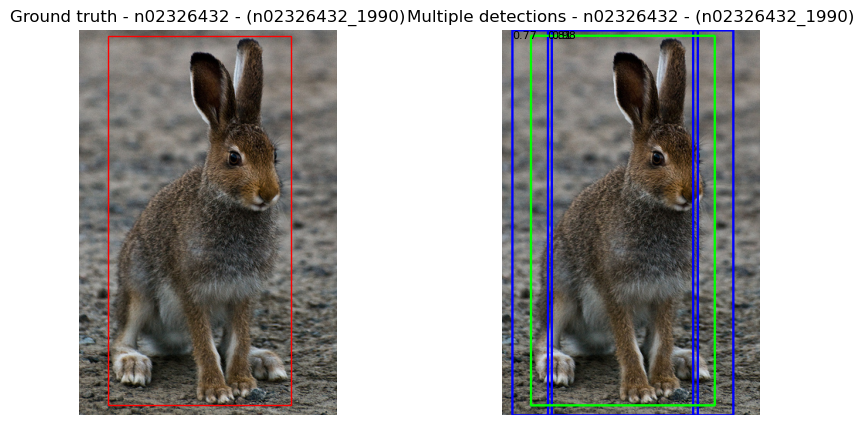

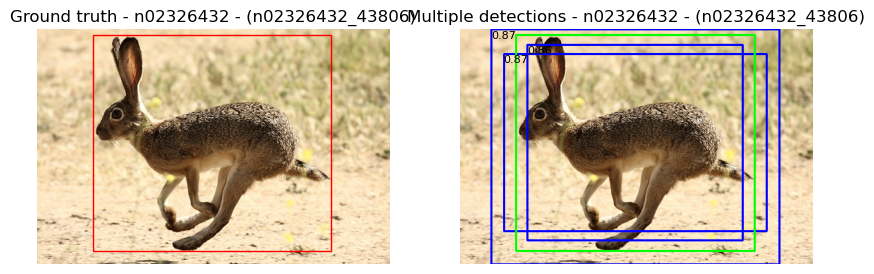

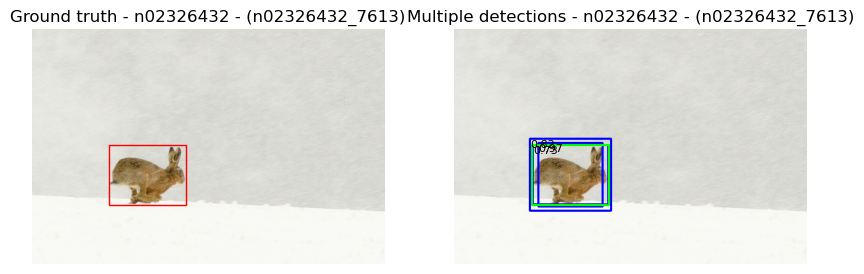

Category: n02397096


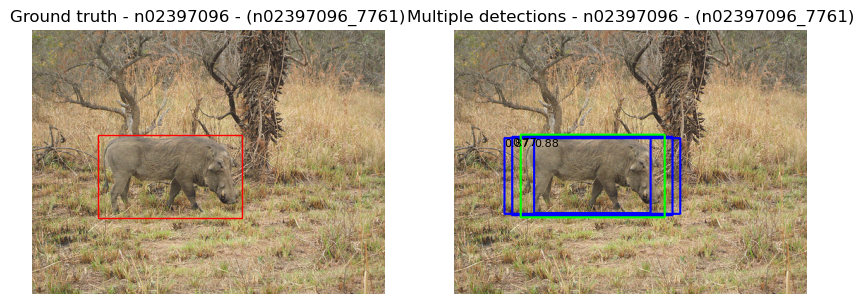

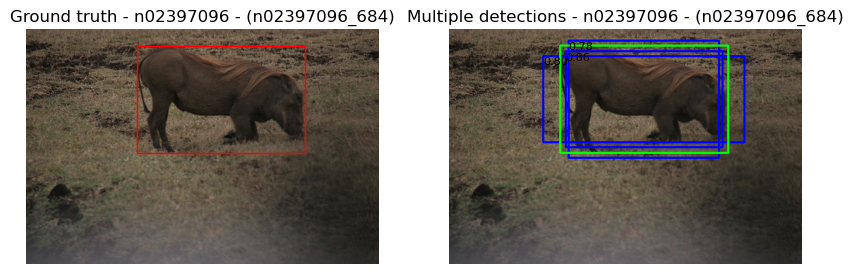

In [86]:
selected_images = {}
for category in categories:
    image_list = os.listdir(os.path.join(dataset_folder, category))
    if len(image_list) >= 5:
        selected_images[category] = random.sample(image_list, 5)
    else:
        selected_images[category] = image_list  # If less than 5 images, select all

# Check if there are less than 5 images for any category and randomly select additional images until there are 5
for category, images in selected_images.items():
    while len(images) < 5:
        remaining_images = set(os.listdir(os.path.join(dataset_folder, category))) - set(images)
        selected_images[category].append(random.choice(list(remaining_images)))

# Iterate over each category and selected images
for category, images in selected_images.items():
    print(f"Category: {category}")
    for image_file in images:
        image_name, _ = os.path.splitext(image_file)
        xml_file = os.path.join(annotation_folder, category, image_name + ".xml")
        if not os.path.exists(xml_file):
            continue
        class_label, bbox = parse_annotation(xml_file)
        image_path = os.path.join(dataset_folder, category, image_file)

        # Initialize lists to store bounding boxes and probabilities
        bboxes = []
        probs = []
        
        # Load the image
        image = plt.imread(image_path)
        
        # Add the object of interest three times with bounding boxes centered around it
        for _ in range(3):
            # Calculate the center of the object of interest
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            width = bbox[2] - bbox[0]
            height = bbox[3] - bbox[1]

            # Generate three bounding boxes for each object
            for _ in range(3):  
                # Randomly vary the width and height of the bounding box
                new_width = width + random.randint(-width // 4, width // 4)
                new_height = height + random.randint(-height // 4, height // 4)

                # Calculate the new bounding box coordinates
                new_xmin = max(0, int(center_x - new_width / 2))
                new_ymin = max(0, int(center_y - new_height / 2))
                new_xmax = min(image.shape[1], int(center_x + new_width / 2))
                new_ymax = min(image.shape[0], int(center_y + new_height / 2))

                # Assign a probability based on IoU with ground truth
                prob = random.uniform(0.7, 1.0) if calculate_iou(bbox, (new_xmin, new_ymin, new_xmax, new_ymax)) > 0.5 else random.uniform(0.1, 0.5)
                bboxes.append((new_xmin, new_ymin, new_xmax, new_ymax))
                probs.append(prob)
                
                # Limit the number of bounding boxes to 3
                if len(bboxes) == 3:
                    break
            if len(bboxes) == 3:
                break

        # Plot the image with the bounding boxes and probabilities
        plot_image_with_bboxes_and_probabilities(image_path, class_label, bbox, bboxes, 1.0, probs, image_name)
